In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Data

In [3]:
!kaggle datasets download -d utkarshps/skin-cancer-mnist10000-ham-augmented-dataset


Dataset URL: https://www.kaggle.com/datasets/utkarshps/skin-cancer-mnist10000-ham-augmented-dataset
License(s): CC-BY-NC-SA-4.0
100%|██████████████████████████████████████▉| 2.76G/2.77G [00:11<00:00, 250MB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:11<00:00, 257MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('skin-cancer-mnist10000-ham-augmented-dataset.zip', 'r')
zip_ref.extractall('/kaggle/working/')
zip_ref.close()

# Importing Dependencies

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,GlobalAveragePooling2D, Flatten, Dropout

from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from keras import regularizers
from keras.layers import Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/working/base_dir/train_dir',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/working/base_dir/val_dir',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 38569 files belonging to 7 classes.
Found 938 files belonging to 7 classes.


# Data Visualization

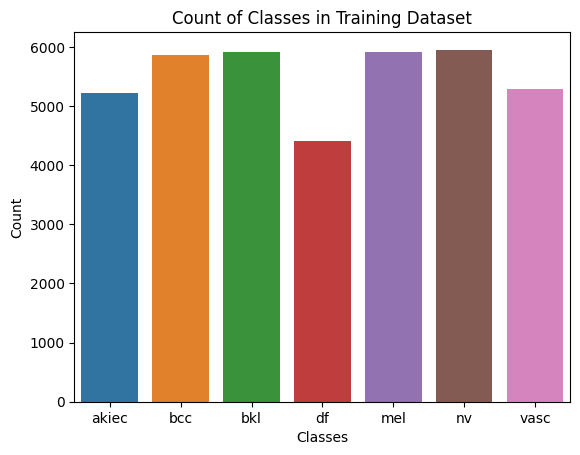

In [7]:
# Extract class labels from the dataset
class_names = train_ds.class_names
class_labels = []
for images, labels in train_ds.unbatch():

    class_labels.append(labels.numpy()) # appending all the integer labels of each iamges in train ds and appending in class_labels which is the size of 38569

# Convert to a numpy array
class_labels = np.array(class_labels)

# Create a count plot
sns.countplot(x=class_labels)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Count of Classes in Training Dataset')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=0)
plt.show()

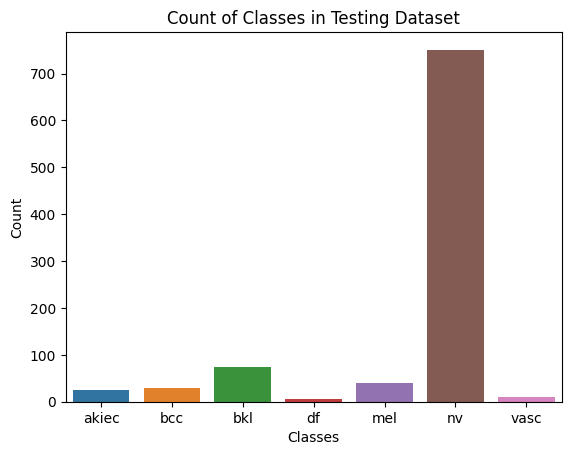

In [8]:
# Extract class labels from the dataset
class_names = validation_ds.class_names
class_labels = []
for images, labels in validation_ds.unbatch():

    class_labels.append(labels.numpy())

# Convert to a numpy array
class_labels = np.array(class_labels)

# Create a count plot
sns.countplot(x=class_labels)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Count of Classes in Testing Dataset')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=0)
plt.show()

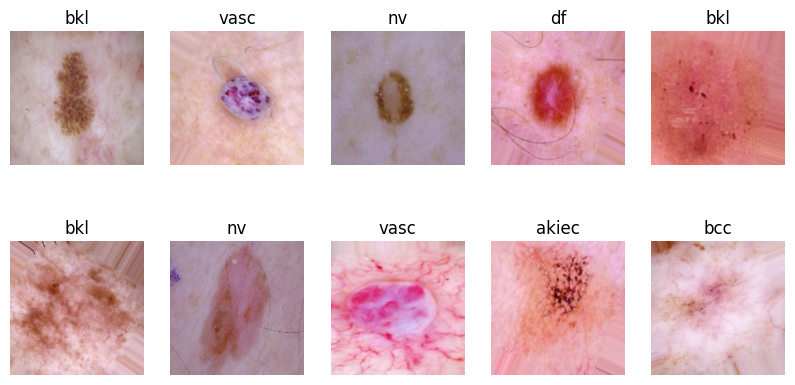

In [9]:
# print sample images form train dataset
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Get a batch of images and labels from the dataset
for images, labels in train_ds.take(1):
    plot_images(images, labels, class_names)
    break

plt.show()

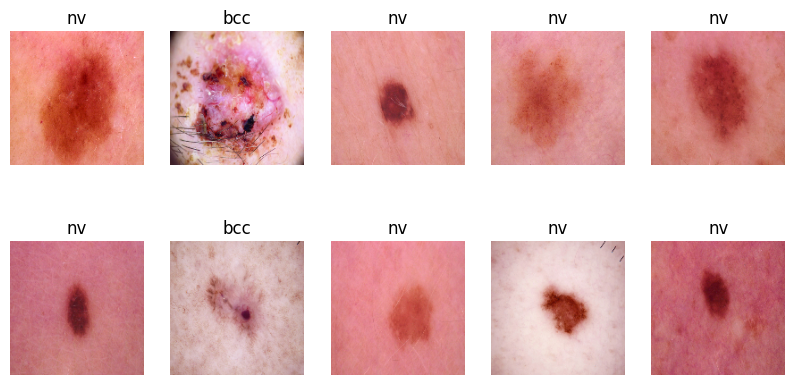

In [10]:
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Get a batch of images and labels from the dataset
for images, labels in validation_ds.take(1):
    plot_images(images, labels, class_names)
    break

plt.show()

In [11]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/150. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

# Model Prepration

In [7]:
model = Sequential()
model.add(Lambda(lambda x: x, input_shape=(150,150, 3)))
model.add(ResNet50(weights='imagenet', include_top=False))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2)) 
model.add(Dense(7, activation='softmax'))
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,696,967 (139.99 MB)

 Trainable params: 36,643,847 (139.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

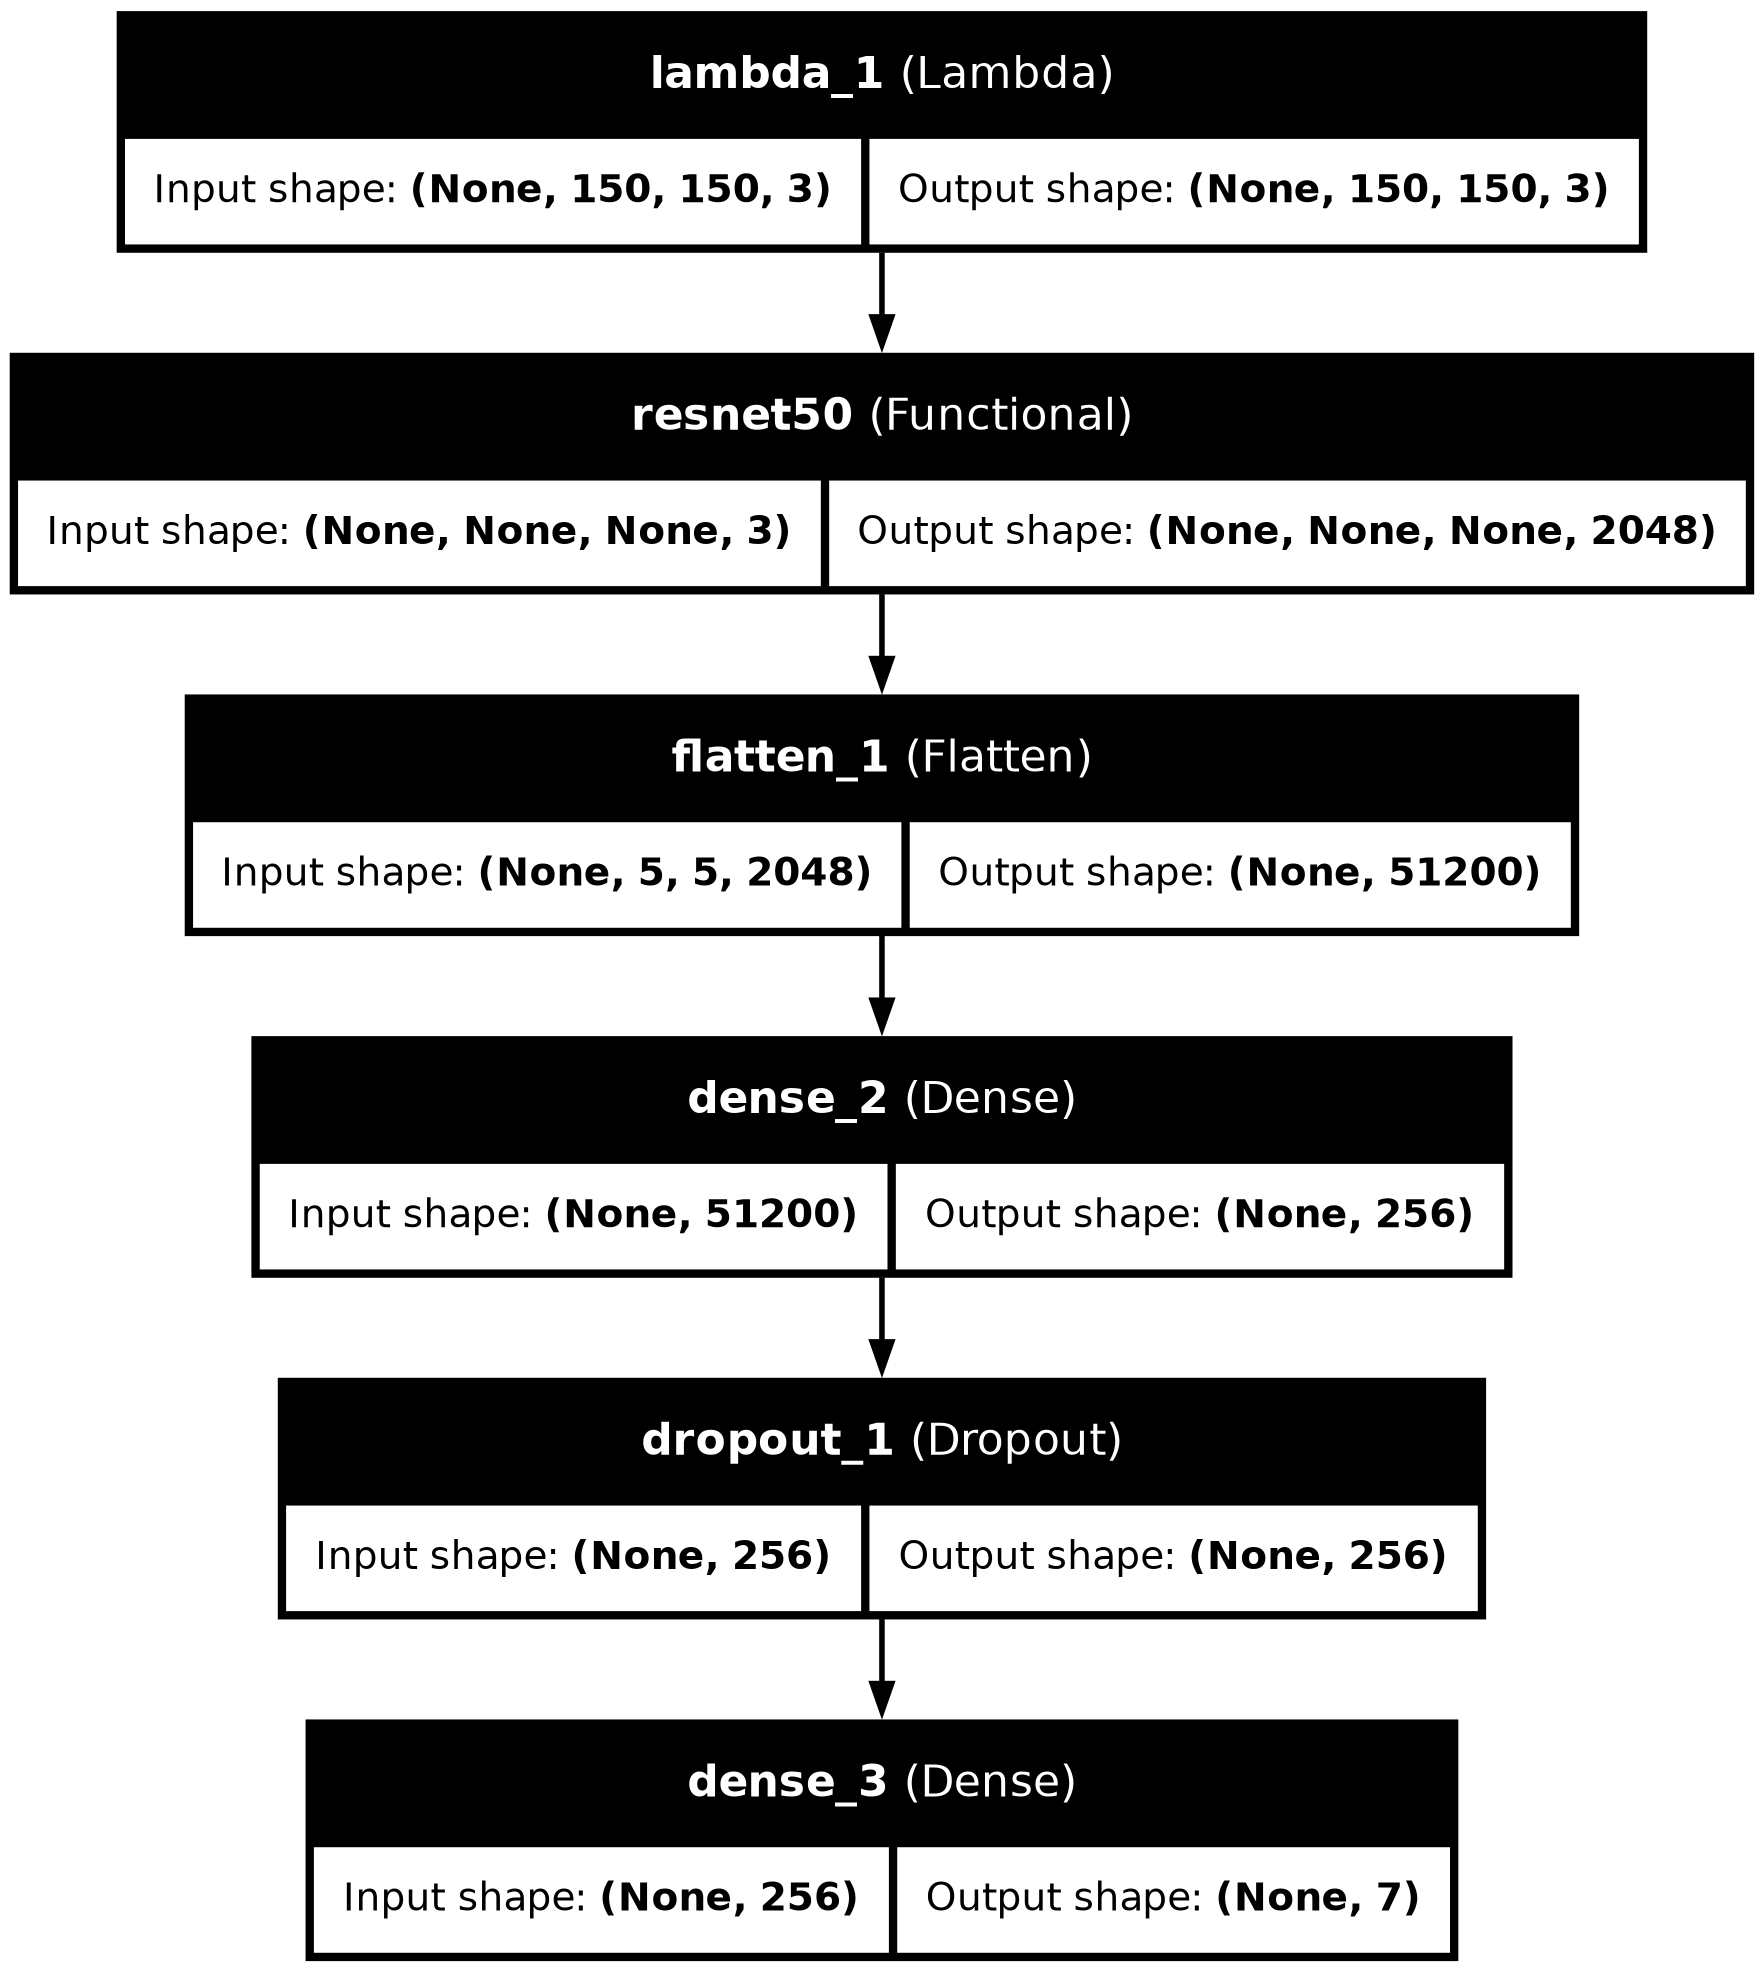

In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Training Model

In [ ]:
history = model.fit(train_ds,epochs=50,validation_data=validation_ds)

Epoch 1/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5385 - loss: 2.2696

I0000 00:00:1725022251.148506     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_45', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_42', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_39', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_38', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 4 bytes spill stores, 12 bytes spill loads



1206/1206 ━━━━━━━━━━━━━━━━━━━━ 149s 124ms/step - accuracy: 0.5385 - loss: 2.2690 - val_accuracy: 0.7985 - val_loss: 0.8225
Epoch 2/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 122s 101ms/step - accuracy: 0.6976 - loss: 0.9531 - val_accuracy: 0.8124 - val_loss: 0.8096
Epoch 3/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 122s 101ms/step - accuracy: 0.7405 - loss: 0.8009 - val_accuracy: 0.8348 - val_loss: 0.6719
Epoch 4/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 122s 101ms/step - accuracy: 0.7331 - loss: 0.8533 - val_accuracy: 0.0842 - val_loss: 8.0979
Epoch 5/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 122s 101ms/step - accuracy: 0.7221 - loss: 0.9279 - val_accuracy: 0.6684 - val_loss: 1.8686
Epoch 6/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 142s 101ms/step - accuracy: 0.7567 - loss: 0.7746 - val_accuracy: 0.8038 - val_loss: 0.7779
Epoch 7/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 121s 101ms/step - accuracy: 0.8019 - loss: 0.6154 - val_accuracy: 0.8422 - val_loss: 0.6570
Epoch 8/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 120s 100ms/step - accuracy: 0.8

# Save the model

In [ ]:

model.save('/kaggle/working/skin_cancer.keras')



In [ ]:
!ls /kaggle/working/


In [ ]:

model.save('/kaggle/working/skin_cancer2.h5')

In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/kaggle/working/skin_cancer2.h5')

# Check for Overfitting

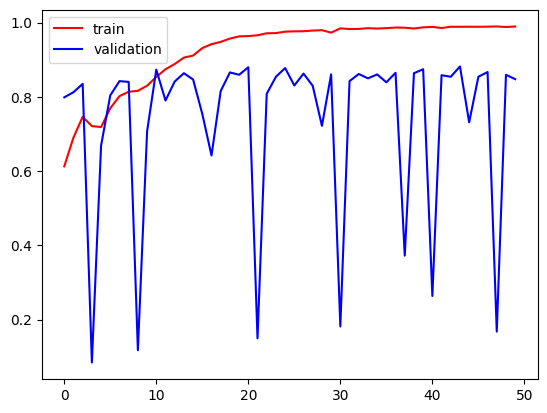

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

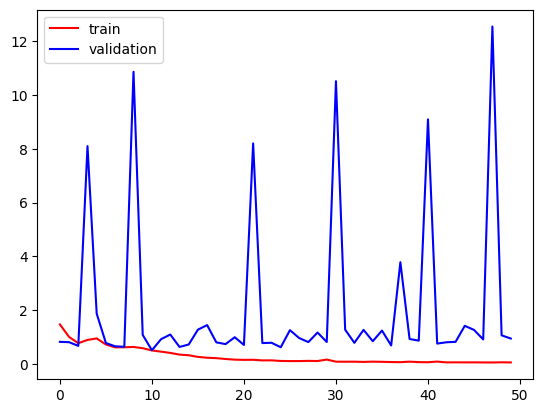

In [18]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Model Evaluation

In [33]:
loss, accuracy = model.evaluate(validation_ds, verbose=1)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8493 - loss: 0.9344


In [34]:
loss

0.9451586604118347

In [35]:
accuracy

0.8475479483604431

In [22]:
# Get the true labels and predicted labels
y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_pred_probs = model.predict(validation_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step


In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)


In [25]:
cm = confusion_matrix(y_true, y_pred)


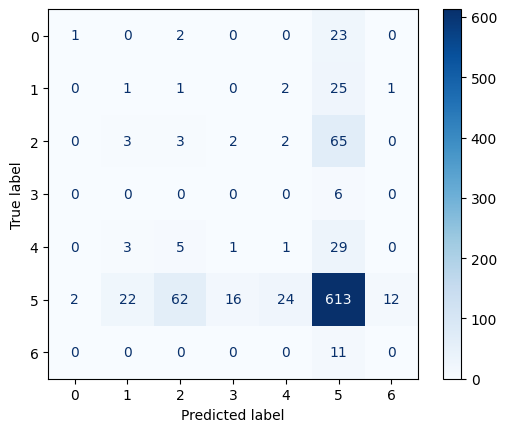

In [26]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
